In [2]:
import numpy as np
import pandas as pd

from category_encoders import LeaveOneOutEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import _rebuild
_rebuild()
plt.rcParams['font.family']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用于正常显示负号

from statsmodels.stats.multitest import multipletests

from utilitis.feature_manager import FeatureManager

%load_ext autoreload
%autoreload 2

## 导入数据

In [3]:
def date_parser(x):
    try:
        return pd.datetime.strptime(x, "%Y%m%d")
    except:
        return np.nan

In [4]:
df = pd.read_csv('data/used_car_train_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'], date_parser=date_parser)
print(df.shape)
df['logPrice'] = np.log(df['price'])
df.head(3)

(150000, 31)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,logPrice
0,0,736,2004-04-02,30.0,6,1.0,0.0,0.0,60,12.5,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,7.522941
1,1,2262,2003-03-01,40.0,1,2.0,0.0,0.0,0,15.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,8.188689
2,2,14874,2004-04-03,115.0,15,1.0,0.0,0.0,163,12.5,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,8.735847


## 分类变量

变量`model`为`车型编码`，为高基类的分类型变量，从下列统计信息可以看出，count > 2000的类别只有19个

*图为各分类计数的累计和图，可以看出count值超过2000的类别其实非常少*

cate counts 248
cate count > 2000:  19


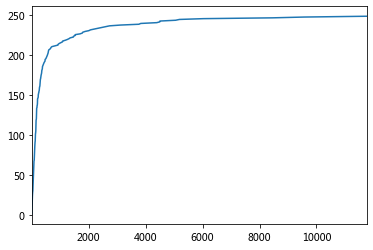

In [5]:
print('cate counts', len(df.model.value_counts()))
print('cate count > 2000: ', sum(df.model.value_counts() > 2000))
np.cumsum(df.model.value_counts().value_counts().sort_index()).plot()

再看一下计数 < 2000 和 > 2000的数据结局是否有明显差异

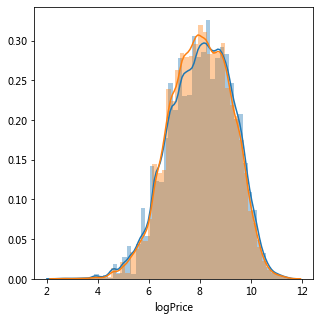

In [6]:
cut_off = 50
feat = df['regionCode']
cat_sparse = feat.value_counts()[feat.value_counts() < cut_off].index
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.distplot(df[feat.isin(cat_sparse)]['logPrice'], hist=True, ax=ax)
sns.distplot(df[~feat.isin(cat_sparse)]['logPrice'], hist=True, ax=ax)

根据以上分析，稍后准备数据集时，我们可以把计数大于2000的类别做一个onehot，同时再新增一个target encoding

变量`'brand', 'bodyType', 'fuelType'`为分类型变量，且类别基数较小，可以直接onehot处理

变量`'regionCode'`是地区代码，但已经经过脱敏，

In [7]:
df['regionCode'].value_counts()#.plot(kind='hist', bins=20)

419     369
764     258
125     137
176     136
462     134
       ... 
6414      1
7063      1
4239      1
5931      1
7267      1
Name: regionCode, Length: 7905, dtype: int64

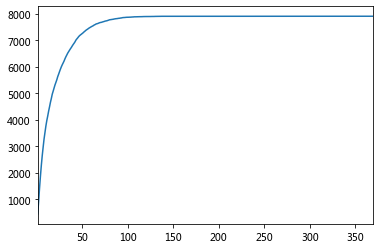

In [8]:
np.cumsum(df.regionCode.value_counts().value_counts().sort_index()).plot()

In [9]:
sum(df['regionCode'].value_counts() > 50)

649

通过设置计数阈值的方法无法有效缩减分类数量，直接用target encoding处理

论坛有人透露name在实验中显示有较大信息量，我们可以进行探索。首先看看有多少基类

In [10]:
df['name'].value_counts()

708       282
387       282
55        280
1541      263
203       233
         ... 
5074        1
7123        1
11221       1
13270       1
174485      1
Name: name, Length: 99662, dtype: int64

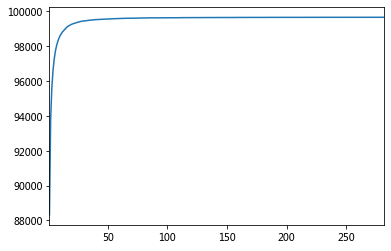

In [11]:
np.cumsum(df['name'].value_counts().value_counts().sort_index()).plot()

In [13]:
sum(df['name'].value_counts() > 50)

100

和`regionCode`一样通过设置计数阈值的方法无法有效缩减分类数量，直接用target encoding处理

## 数值变量

第一个变量是`power`，范围应该在0-600，从统计结果来看有离群点，把>600的处理为空

/opt/tljh/user/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


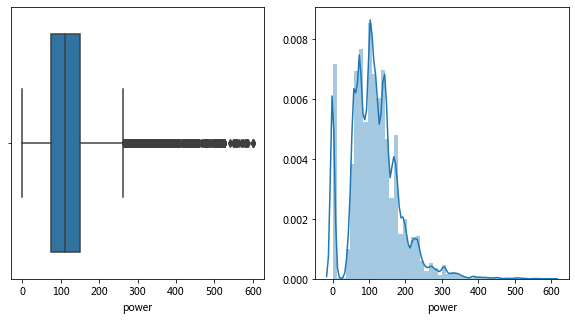

In [16]:
power = df['power']
power.loc[power > 600] = np.nan
_, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(power, ax=axes[0])
sns.distplot(power.dropna(), hist=True, ax=axes[1])

分布呈长尾且有部分数据集中为0，取log并把0值替换为nan

In [21]:
df['kilometer'].value_counts()

15.0    96877
12.5    15722
10.0     6459
9.0      5257
8.0      4573
7.0      4084
6.0      3725
5.0      3144
4.0      2718
3.0      2501
2.0      2354
0.5      1840
1.0       746
Name: kilometer, dtype: int64

`kilometer`实际是rank类型，暂时不做处理

变量`v5`、`v6`存在离群的0点，替换为nan

变量`v7`存在离群点，删掉 >0.5的数据，同理`v11`删除 >10数据，`v13`、`v14`删除 >7.5的数据

变量`v10`存在明显的3峰，尝试拆分为3个变量 ((,0], \[0, 6), (8,))

## 日期特征

此外汽车销售存在季节性变量，二手车交易时间和季节有很强关联，买入时间的季节和原价相关，也可能影响卖出价格。我们可以探索一下年和月以及是否周末对结局的影响

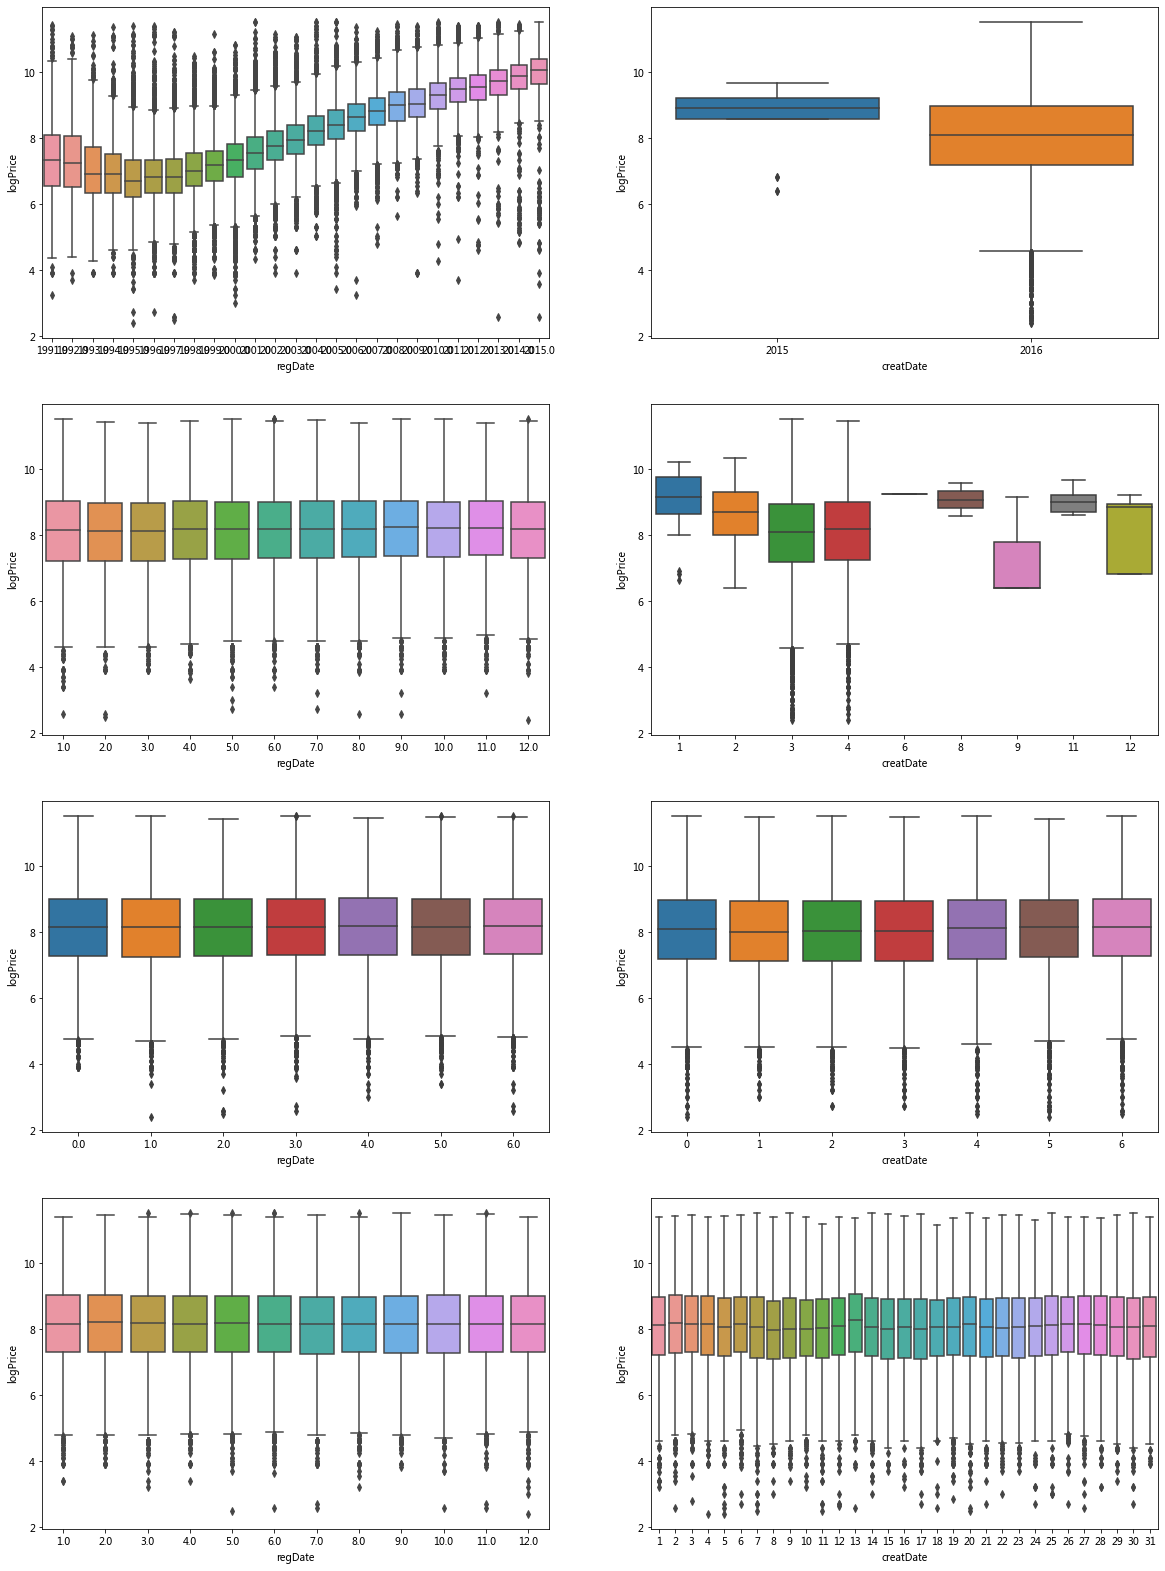

In [35]:
f, axes = plt.subplots(4, 2, figsize=(20, 28))
for i, feat in enumerate(['regDate', 'creatDate']):
    sns.boxplot(df[feat].dt.year, df['logPrice'], ax=axes[0, i])
    sns.boxplot(df[feat].dt.month, df['logPrice'], ax=axes[1, i])
    sns.boxplot(df[feat].dt.dayofweek, df['logPrice'], ax=axes[2, i])
    sns.boxplot(df[feat].dt.day, df['logPrice'], ax=axes[3, i])

可以看到`'regDate', 'creatDate'`的年份以及`'creatDate'`的月份可能包含较多信息。但年份信息和汽车使用时长有关，所以只添加`'creatDate'`的月份这一特征

In [37]:
import xgboost as xgb

In [41]:
xgb.os.

xgboost.tracker.RabitTracker

In [43]:
import os

In [44]:
os.system('nvcc --version')

32512

In [45]:
sum(df['name'].value_counts() > 50)

100

In [53]:
df.loc[df['name'].isin((df['name'].value_counts() > 50).index), 'name1'] = df.loc[df['name'].isin(df['name'].value_counts()[df['name'].value_counts() > 50].index), 'name']

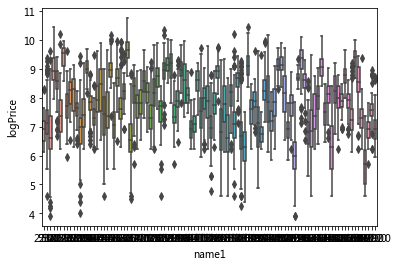

In [56]:
sns.boxplot(df['name1'], df['logPrice'])